# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH, HARX
from vol_predict.models.baselines.benchmarks import ENET, RF, XGBM

sns.set(style="whitegrid")
# sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
NUM_LAGS = 10
LAGS = [1, 6, 24]  # for HARX moving averages

full_data = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .to_pandas()
    .set_index("datetime")
)

for i in range(1, NUM_LAGS + 1):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilitiess
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, NUM_LAGS + 1):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

full_data.loc[:, ["log_volume"]] = np.log(full_data.loc[:, "volume"] + 0.0000001)

raw_features_names = [
    "spread",
    # "ask_depth", # = const
    "bid_depth",
    # "depth_diff", # = bid_depth - ask_depth(const)
    "ask_volume",
    "bid_volume",  # eliminated in the features engineering stage
    "volume_diff",  # = bid_volume - ask_volume (redundant in linear models)
    "weighted_spread",  #  eliminated in the features engineering stage, no correlation with volatility
    "ask_slope",
    "bid_slope",  # eliminated in the features engineering stage, very correlated with ask_slope
]


for col in raw_features_names:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    # sort columns by the time delta, e.g. "bid_volume_t-1", "bid_volume_t-2", ..., "bid_volume_t-60"
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))

    full_data[f"mean_{col}"] = full_data.loc[
        :, full_data.columns.str.startswith(col)
    ].mean(axis=1)
    full_data[f"iq_range_{col}"] = np.log(
        0.0001
        + (
            full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1)
            - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1)
        )
        / full_data.loc[:, columns_to_use[:]].median(axis=1)
    )
    full_data[f"trend_{col}"] = full_data.loc[:, columns_to_use[:60]].mean(
        axis=1
    ) - full_data.loc[:, columns_to_use[60:]].mean(axis=1)

# moving average of log_vol_lag1. These are the main features of HAR model
for lag in LAGS:
    full_data.loc[:, f"log_vol_lag1_smooth{lag}"] = (
        full_data.loc[:, "log_vol_lag1"].rolling(window=lag).mean()
    )

selected_ob_features = [
    "mean_spread",
    "mean_bid_depth",
    "mean_ask_volume",
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_ask_slope",
]

large_ob_features = [
    "mean_spread",
    "mean_bid_depth",
    "mean_ask_volume",
    "mean_bid_volume",
    "mean_weighted_spread",
    "mean_ask_slope",
    "mean_bid_slope",
    "trend_spread",
    "trend_bid_depth",
    "trend_ask_volume",
    "trend_bid_volume",
    "trend_weighted_spread",
    "trend_ask_slope",
    "trend_bid_slope",
    "iq_range_spread",
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_bid_volume",
    "iq_range_weighted_spread",
    "iq_range_ask_slope",
    "iq_range_bid_slope",
]


dataset = full_data.loc[
    :,
    # RESPONSE
    ["vol", "ret", "log_vol"]
    +
    # ['log_vol']   +
    # FEATURES
    [f"vol_lag{i}" for i in range(1, NUM_LAGS + 1)]
    + [f"log_vol_lag{i}" for i in range(1, NUM_LAGS + 1)]
    + [f"log_vol_lag1_smooth{lag}" for lag in LAGS]
    + ["log_volume"]
    + large_ob_features,
].dropna()


# LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
# init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
dataset.columns

Index(['vol', 'ret', 'log_vol', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'vol_lag4',
       'vol_lag5', 'vol_lag6', 'vol_lag7', 'vol_lag8', 'vol_lag9', 'vol_lag10',
       'log_vol_lag1', 'log_vol_lag2', 'log_vol_lag3', 'log_vol_lag4',
       'log_vol_lag5', 'log_vol_lag6', 'log_vol_lag7', 'log_vol_lag8',
       'log_vol_lag9', 'log_vol_lag10', 'log_vol_lag1_smooth1',
       'log_vol_lag1_smooth6', 'log_vol_lag1_smooth24', 'log_volume',
       'mean_spread', 'mean_bid_depth', 'mean_ask_volume', 'mean_bid_volume',
       'mean_weighted_spread', 'mean_ask_slope', 'mean_bid_slope',
       'trend_spread', 'trend_bid_depth', 'trend_ask_volume',
       'trend_bid_volume', 'trend_weighted_spread', 'trend_ask_slope',
       'trend_bid_slope', 'iq_range_spread', 'iq_range_bid_depth',
       'iq_range_ask_volume', 'iq_range_bid_volume',
       'iq_range_weighted_spread', 'iq_range_ask_slope', 'iq_range_bid_slope'],
      dtype='object')

In [5]:
output_template = pd.read_csv(data_path / "btc" / "output_template.csv", index_col=0)
output_template.index = pd.to_datetime(output_template.index)

In [6]:
output_template

,retraining_flag,model_name
datetime,,
2018-07-03 23:00:00,True,NaN
2018-07-04 00:00:00,False,NaN
2018-07-04 01:00:00,False,NaN
2018-07-04 02:00:00,False,NaN
2018-07-04 03:00:00,False,NaN
...,...,...
2018-09-30 17:00:00,False,NaN
2018-09-30 18:00:00,False,NaN
2018-09-30 19:00:00,False,NaN


In [7]:
IS_EXPANDING = True
suffix = "expanding" if IS_EXPANDING else "rolling"
LOOK_BACK = pd.Timedelta(days=30)

In [8]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [9]:
backtester = BenchmarkBacktester(
    dataset=dataset,
    output_template=output_template,
    last_train_date=LAST_TRAINING_DATE,
    is_training_expanded=IS_EXPANDING,
    lookback=LOOK_BACK,
)

# Backtesting Univariate models

## Naive

100%|██████████| 1958/1958 [00:03<00:00, 525.14it/s]


Backtest finished successfully.
---------------------------------------------------
Model: Naive
RMSE: 0.0002826
MAE:  0.0000921
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


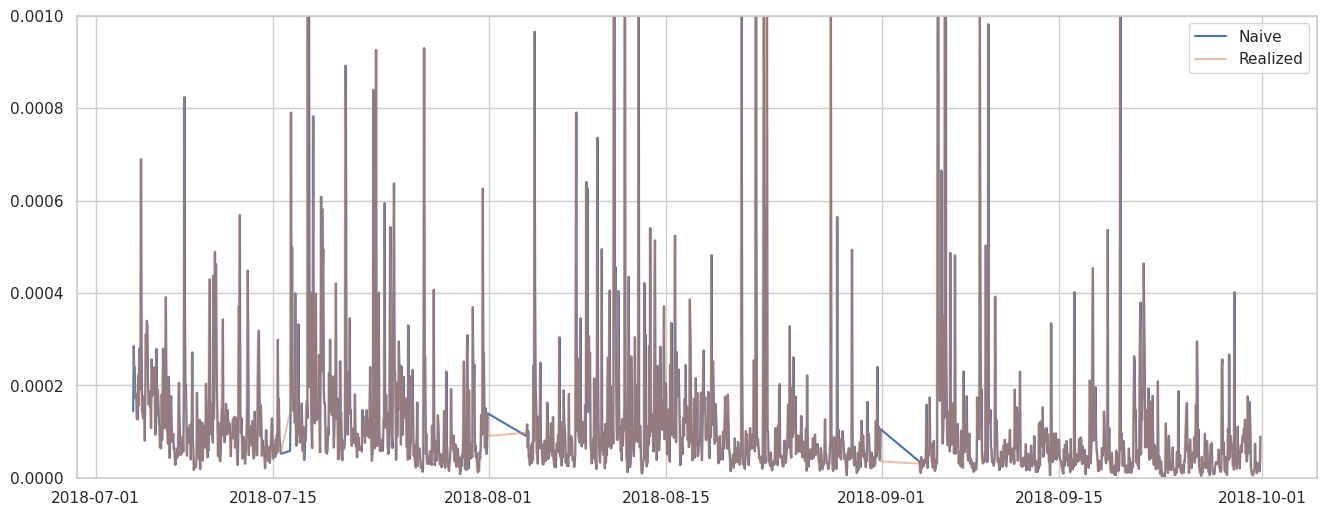

In [10]:
backtest_results_naive = backtester.backtest(Naive, use_ob_feats=False, use_log_y=False)

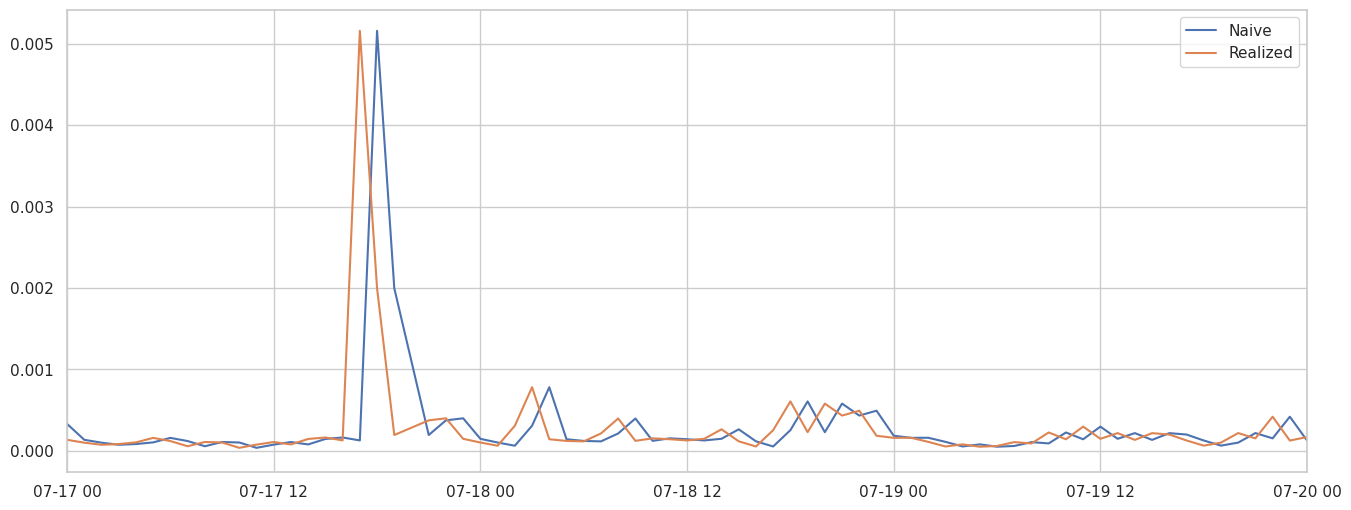

In [11]:
plt.plot(backtest_results_naive.forecasts, label="Naive")
plt.plot(backtest_results_naive.true_vola, label="Realized")
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()

In [12]:
backtest_results_naive.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"naive_{suffix}.csv",
    index=True,
)

## EWMA

100%|██████████| 1958/1958 [00:04<00:00, 473.22it/s]


Backtest finished successfully.
---------------------------------------------------
Model: EWMA
RMSE: 0.0002551
MAE:  0.0000938
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


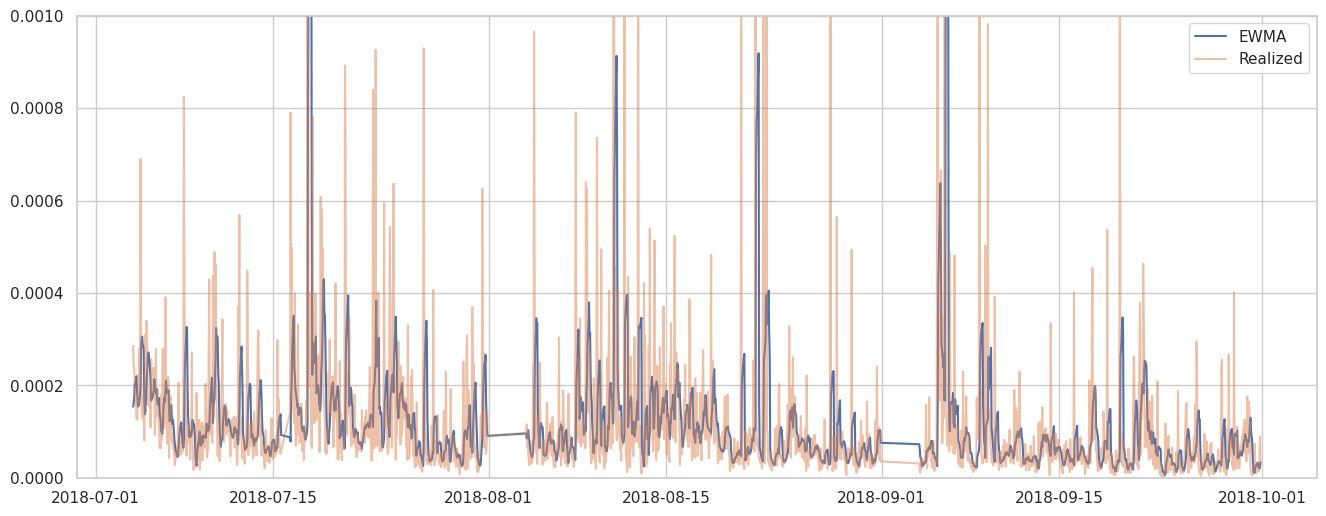

In [13]:
backtest_results_ewma = backtester.backtest(
    EWMA,
    hyperparams={"look_back": 6, "half_life": 12},
    use_ob_feats=False,
    use_log_y=False,
)

In [14]:
backtest_results_ewma.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"ewma_{suffix}.csv",
    index=True,
)

<Axes: xlabel='datetime'>

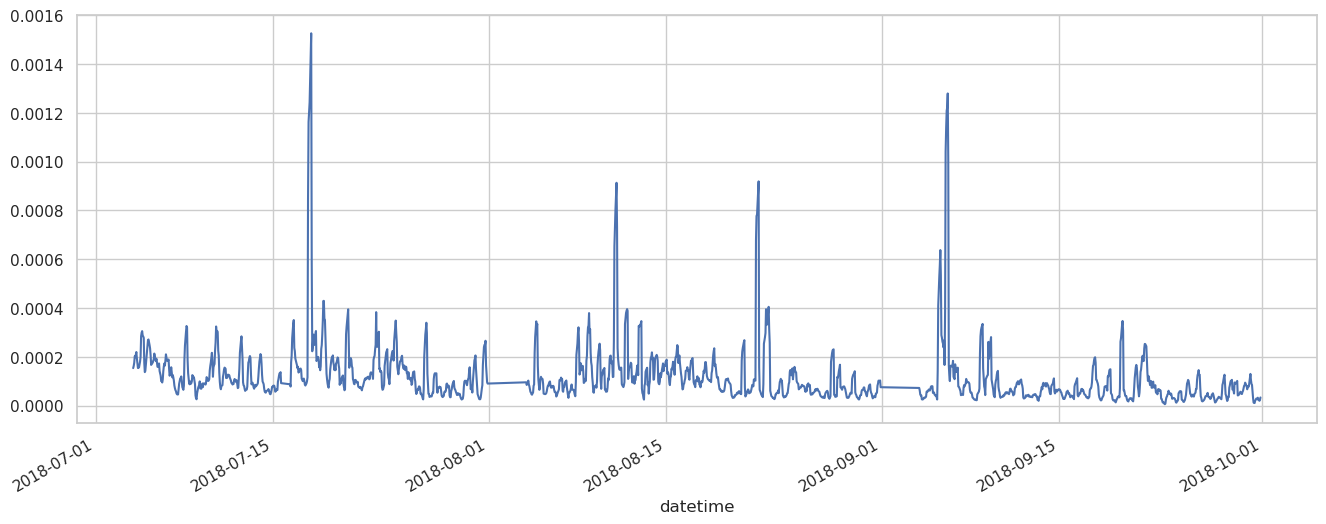

In [15]:
backtest_results_ewma.forecasts.plot(label="EWMA")

## ARIMA

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 8/1958 [00:00<01:02, 31.21it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  597
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -474.843
Date:                Mon, 30 Jun 2025   AIC                            957.686
Time:                        14:16:21   BIC                            975.254
Sample:                             0   HQIC                           964.527
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6036      0.090    -95.786      0.000      -8.780      -8.428
ar.L1          0.8353      0.033     25.651      0.000       0.771       0.899
ma.L1         -0.3434      0.055     -6.293      0.0

  6%|▋         | 127/1958 [00:02<00:37, 48.87it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  716
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -568.074
Date:                Mon, 30 Jun 2025   AIC                           1144.148
Time:                        14:16:23   BIC                           1162.442
Sample:                             0   HQIC                          1151.212
                                - 716                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6787      0.086   -101.349      0.000      -8.847      -8.511
ar.L1          0.8371      0.030     28.086      0.000       0.779       0.895
ma.L1         -0.3198      0.050     -6.450      0.0

 12%|█▏        | 242/1958 [00:04<00:43, 39.44it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -683.239
Date:                Mon, 30 Jun 2025   AIC                           1374.479
Time:                        14:16:25   BIC                           1393.379
Sample:                             0   HQIC                          1381.726
                                - 833                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7397      0.075   -116.186      0.000      -8.887      -8.592
ar.L1          0.8144      0.029     28.446      0.000       0.758       0.871
ma.L1         -0.2858      0.047     -6.110      0.0

 18%|█▊        | 350/1958 [00:06<00:45, 35.68it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  936
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -801.695
Date:                Mon, 30 Jun 2025   AIC                           1611.389
Time:                        14:16:28   BIC                           1630.756
Sample:                             0   HQIC                          1618.773
                                - 936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7629      0.073   -119.339      0.000      -8.907      -8.619
ar.L1          0.8104      0.028     28.608      0.000       0.755       0.866
ma.L1         -0.2877      0.045     -6.394      0.0

 24%|██▍       | 466/1958 [00:08<00:40, 36.71it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1055
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -918.993
Date:                Mon, 30 Jun 2025   AIC                           1845.987
Time:                        14:16:30   BIC                           1865.832
Sample:                             0   HQIC                          1853.509
                               - 1055                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8029      0.066   -134.213      0.000      -8.931      -8.674
ar.L1          0.7912      0.029     27.554      0.000       0.735       0.847
ma.L1         -0.2748      0.043     -6.318      0.0

 30%|██▉       | 585/1958 [00:11<00:41, 33.12it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1174
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1063.461
Date:                Mon, 30 Jun 2025   AIC                           2134.921
Time:                        14:16:32   BIC                           2155.194
Sample:                             0   HQIC                          2142.566
                               - 1174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8728      0.067   -133.255      0.000      -9.003      -8.742
ar.L1          0.7964      0.025     31.385      0.000       0.747       0.846
ma.L1         -0.2672      0.038     -6.972      0.0

 33%|███▎      | 649/1958 [00:12<00:27, 47.78it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 654/1958 [00:13<00:56, 23.25it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1246
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1156.816
Date:                Mon, 30 Jun 2025   AIC                           2321.631
Time:                        14:16:34   BIC                           2342.142
Sample:                             0   HQIC                          2329.343
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9157      0.068   -131.762      0.000      -9.048      -8.783
ar.L1          0.8023      0.024     33.463      0.000       0.755       0.849
ma.L1         -0.2686      0.037     -7.274      0.0

 38%|███▊      | 749/1958 [00:15<00:54, 22.01it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1342
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1262.796
Date:                Mon, 30 Jun 2025   AIC                           2533.593
Time:                        14:16:37   BIC                           2554.400
Sample:                             0   HQIC                          2541.387
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9613      0.068   -131.854      0.000      -9.095      -8.828
ar.L1          0.8092      0.023     35.380      0.000       0.764       0.854
ma.L1         -0.2804      0.035     -7.966      0.0

 44%|████▍     | 868/1958 [00:19<00:53, 20.24it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1443.164
Date:                Mon, 30 Jun 2025   AIC                           2894.329
Time:                        14:16:40   BIC                           2915.479
Sample:                             0   HQIC                          2902.218
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9724      0.061   -146.285      0.000      -9.093      -8.852
ar.L1          0.7794      0.025     31.490      0.000       0.731       0.828
ma.L1         -0.2598      0.035     -7.455      0.0

 51%|█████     | 989/1958 [00:23<00:52, 18.54it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1581
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1576.687
Date:                Mon, 30 Jun 2025   AIC                           3161.373
Time:                        14:16:44   BIC                           3182.836
Sample:                             0   HQIC                          3169.348
                               - 1581                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9859      0.057   -157.835      0.000      -9.097      -8.874
ar.L1          0.7706      0.025     31.041      0.000       0.722       0.819
ma.L1         -0.2608      0.034     -7.631      0.0

 56%|█████▋    | 1106/1958 [00:29<02:06,  6.76it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1701
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1731.602
Date:                Mon, 30 Jun 2025   AIC                           3471.204
Time:                        14:16:51   BIC                           3492.960
Sample:                             0   HQIC                          3479.258
                               - 1701                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0171      0.055   -163.053      0.000      -9.125      -8.909
ar.L1          0.7600      0.025     30.744      0.000       0.712       0.808
ma.L1         -0.2454      0.033     -7.379      0.0

 63%|██████▎   | 1228/1958 [00:34<00:46, 15.74it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1820
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1845.803
Date:                Mon, 30 Jun 2025   AIC                           3699.605
Time:                        14:16:55   BIC                           3721.631
Sample:                             0   HQIC                          3707.731
                               - 1820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0727      0.057   -159.422      0.000      -9.184      -8.961
ar.L1          0.7853      0.023     34.791      0.000       0.741       0.830
ma.L1         -0.2785      0.031     -9.001      0.0

 67%|██████▋   | 1319/1958 [00:37<00:18, 33.78it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 68%|██████▊   | 1323/1958 [00:38<00:40, 15.58it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1916
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1964.604
Date:                Mon, 30 Jun 2025   AIC                           3937.209
Time:                        14:16:59   BIC                           3959.441
Sample:                             0   HQIC                          3945.389
                               - 1916                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1148      0.059   -154.851      0.000      -9.230      -8.999
ar.L1          0.8016      0.021     38.152      0.000       0.760       0.843
ma.L1         -0.3057      0.029    -10.415      0.0

 71%|███████▏  | 1398/1958 [00:40<00:25, 21.92it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1988
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2067.405
Date:                Mon, 30 Jun 2025   AIC                           4142.811
Time:                        14:17:02   BIC                           4165.190
Sample:                             0   HQIC                          4151.031
                               - 1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1224      0.059   -155.644      0.000      -9.237      -9.007
ar.L1          0.7972      0.021     38.298      0.000       0.756       0.838
ma.L1         -0.2964      0.029    -10.346      0.0

 77%|███████▋  | 1510/1958 [00:43<00:18, 23.82it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2102
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2199.685
Date:                Mon, 30 Jun 2025   AIC                           4407.370
Time:                        14:17:05   BIC                           4429.973
Sample:                             0   HQIC                          4415.649
                               - 2102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1557      0.059   -155.652      0.000      -9.271      -9.040
ar.L1          0.8049      0.020     40.198      0.000       0.766       0.844
ma.L1         -0.3125      0.028    -11.204      0.0

 83%|████████▎ | 1627/1958 [00:47<00:25, 12.96it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2221
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2326.369
Date:                Mon, 30 Jun 2025   AIC                           4660.739
Time:                        14:17:09   BIC                           4683.562
Sample:                             0   HQIC                          4669.075
                               - 2221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2040      0.061   -151.392      0.000      -9.323      -9.085
ar.L1          0.8235      0.018     45.232      0.000       0.788       0.859
ma.L1         -0.3401      0.026    -12.957      0.0

 89%|████████▉ | 1748/1958 [00:52<00:14, 14.31it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2341
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2483.022
Date:                Mon, 30 Jun 2025   AIC                           4974.045
Time:                        14:17:13   BIC                           4997.078
Sample:                             0   HQIC                          4982.435
                               - 2341                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2369      0.061   -151.550      0.000      -9.356      -9.117
ar.L1          0.8254      0.017     47.652      0.000       0.791       0.859
ma.L1         -0.3355      0.025    -13.408      0.0

 95%|█████████▌| 1867/1958 [00:56<00:09,  9.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2461
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2647.364
Date:                Mon, 30 Jun 2025   AIC                           5302.728
Time:                        14:17:18   BIC                           5325.961
Sample:                             0   HQIC                          5311.169
                               - 2461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2912      0.065   -142.218      0.000      -9.419      -9.163
ar.L1          0.8472      0.015     55.732      0.000       0.817       0.877
ma.L1         -0.3668      0.023    -15.612      0.0

100%|██████████| 1958/1958 [00:59<00:00, 32.80it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMA
RMSE: 0.0002441
MAE:  0.0000959
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


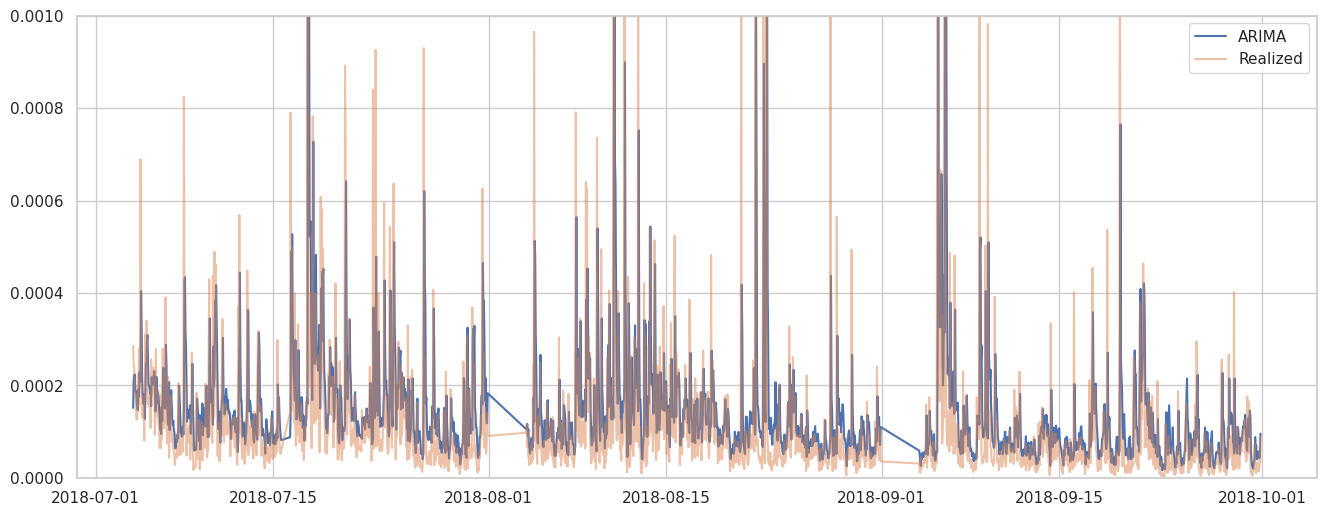

In [16]:
backtest_results_arima = backtester.backtest(
    ARIMAX, hyperparams={"p": 1, "d": 0, "q": 1}, use_ob_feats=False, use_log_y=True
)

In [17]:
backtest_results_arima.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arima_{suffix}.csv",
    index=True,
)

## GARCH

### GARCH(1, 1) with Normal dist.

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.769e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  2%|▏         | 38/1958 [00:00<00:10, 190.07it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2106.46
Distribution:                  Normal   AIC:                          -4204.92
Method:            Maximum Likelihood   BIC:                          -4187.35
                                        No. Observations:                  597
Date:                Mon, Jun 30 2025   Df Residuals:                      596
Time:                        14:23:05   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.0755e-04  2.859e-04     -0.376      0.

  5%|▍         | 97/1958 [00:00<00:10, 175.53it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.201e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  8%|▊         | 150/1958 [00:00<00:08, 222.66it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2564.39
Distribution:                  Normal   AIC:                          -5120.78
Method:            Maximum Likelihood   BIC:                          -5102.48
                                        No. Observations:                  716
Date:                Mon, Jun 30 2025   Df Residuals:                      715
Time:                        14:23:06   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.0942e-05  2.224e-04     -0.229      0.

 12%|█▏        | 236/1958 [00:01<00:06, 264.75it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.746e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 16%|█▌        | 305/1958 [00:01<00:05, 300.39it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3022.54
Distribution:                  Normal   AIC:                          -6037.08
Method:            Maximum Likelihood   BIC:                          -6018.18
                                        No. Observations:                  833
Date:                Mon, Jun 30 2025   Df Residuals:                      832
Time:                        14:23:06   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.1519e-04  2.064e-04     -0.558      0.

 17%|█▋        | 336/1958 [00:01<00:05, 283.11it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.95e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 20%|██        | 397/1958 [00:01<00:05, 276.32it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3371.90
Distribution:                  Normal   AIC:                          -6735.81
Method:            Maximum Likelihood   BIC:                          -6716.44
                                        No. Observations:                  936
Date:                Mon, Jun 30 2025   Df Residuals:                      935
Time:                        14:23:07   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.5907e-05  2.091e-04      0.363      0.717 

 23%|██▎       | 457/1958 [00:01<00:05, 285.17it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.673e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 25%|██▍       | 486/1958 [00:01<00:05, 262.58it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3827.96
Distribution:                  Normal   AIC:                          -7647.93
Method:            Maximum Likelihood   BIC:                          -7628.08
                                        No. Observations:                 1055
Date:                Mon, Jun 30 2025   Df Residuals:                     1054
Time:                        14:23:07   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.0703e-04  1.939e-04      0.552      0.581 

 29%|██▉       | 564/1958 [00:02<00:06, 217.21it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.669e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 31%|███       | 608/1958 [00:02<00:06, 203.54it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4258.65
Distribution:                  Normal   AIC:                          -8509.30
Method:            Maximum Likelihood   BIC:                          -8489.03
                                        No. Observations:                 1174
Date:                Mon, Jun 30 2025   Df Residuals:                     1173
Time:                        14:23:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5109e-04  1.851e-04      0.816      0.414 

 33%|███▎      | 649/1958 [00:02<00:06, 193.65it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.613e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 35%|███▌      | 695/1958 [00:03<00:06, 209.61it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4525.70
Distribution:                  Normal   AIC:                          -9043.40
Method:            Maximum Likelihood   BIC:                          -9022.89
                                        No. Observations:                 1246
Date:                Mon, Jun 30 2025   Df Residuals:                     1245
Time:                        14:23:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.1511e-05  1.758e-04      0.464      0.643 

 38%|███▊      | 740/1958 [00:03<00:05, 207.79it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.587e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 40%|████      | 784/1958 [00:03<00:05, 213.23it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4876.41
Distribution:                  Normal   AIC:                          -9744.83
Method:            Maximum Likelihood   BIC:                          -9724.02
                                        No. Observations:                 1342
Date:                Mon, Jun 30 2025   Df Residuals:                     1341
Time:                        14:23:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.3180e-05  1.696e-04      0.255      0.799 

 43%|████▎     | 848/1958 [00:03<00:05, 197.12it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.974e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 46%|████▌     | 893/1958 [00:03<00:05, 209.37it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5224.38
Distribution:                  Normal   AIC:                          -10440.8
Method:            Maximum Likelihood   BIC:                          -10419.6
                                        No. Observations:                 1462
Date:                Mon, Jun 30 2025   Df Residuals:                     1461
Time:                        14:23:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.4436e-05  1.827e-04      0.188      0.851 

 50%|████▉     | 972/1958 [00:04<00:04, 232.43it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 52%|█████▏    | 1019/1958 [00:04<00:04, 223.30it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5625.21
Distribution:                  Normal   AIC:                          -11242.4
Method:            Maximum Likelihood   BIC:                          -11220.9
                                        No. Observations:                 1581
Date:                Mon, Jun 30 2025   Df Residuals:                     1580
Time:                        14:23:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.8388e-05  1.868e-04      0.420      0.675 

 56%|█████▌    | 1087/1958 [00:04<00:04, 205.19it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.125e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 58%|█████▊    | 1137/1958 [00:05<00:03, 227.26it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6027.67
Distribution:                  Normal   AIC:                          -12047.3
Method:            Maximum Likelihood   BIC:                          -12025.6
                                        No. Observations:                 1701
Date:                Mon, Jun 30 2025   Df Residuals:                     1700
Time:                        14:23:10   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.0060e-05  1.997e-04      0.451      0.652 

 62%|██████▏   | 1218/1958 [00:05<00:03, 233.76it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.875e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 65%|██████▍   | 1266/1958 [00:05<00:02, 234.29it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6499.70
Distribution:                  Normal   AIC:                          -12991.4
Method:            Maximum Likelihood   BIC:                          -12969.4
                                        No. Observations:                 1820
Date:                Mon, Jun 30 2025   Df Residuals:                     1819
Time:                        14:23:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3458e-04  1.873e-04      0.718      0.473 

 67%|██████▋   | 1314/1958 [00:05<00:02, 228.50it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.742e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 70%|██████▉   | 1365/1958 [00:06<00:02, 238.89it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6868.34
Distribution:                  Normal   AIC:                          -13728.7
Method:            Maximum Likelihood   BIC:                          -13706.5
                                        No. Observations:                 1916
Date:                Mon, Jun 30 2025   Df Residuals:                     1915
Time:                        14:23:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.4879e-04  1.779e-04      0.836      0.403 

 71%|███████   | 1389/1958 [00:06<00:02, 221.98it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.834e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 72%|███████▏  | 1412/1958 [00:06<00:02, 191.74it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7114.89
Distribution:                  Normal   AIC:                          -14221.8
Method:            Maximum Likelihood   BIC:                          -14199.4
                                        No. Observations:                 1988
Date:                Mon, Jun 30 2025   Df Residuals:                     1987
Time:                        14:23:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1736e-04  1.775e-04      0.661      0.509 

 77%|███████▋  | 1505/1958 [00:06<00:02, 205.98it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.738e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 79%|███████▉  | 1554/1958 [00:07<00:01, 222.33it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7540.78
Distribution:                  Normal   AIC:                          -15073.6
Method:            Maximum Likelihood   BIC:                          -15051.0
                                        No. Observations:                 2102
Date:                Mon, Jun 30 2025   Df Residuals:                     2101
Time:                        14:23:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.0755e-04  1.745e-04      0.616      0.538 

 82%|████████▏ | 1602/1958 [00:07<00:01, 219.85it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.556e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 85%|████████▍ | 1656/1958 [00:07<00:01, 233.93it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8014.63
Distribution:                  Normal   AIC:                          -16021.3
Method:            Maximum Likelihood   BIC:                          -15998.4
                                        No. Observations:                 2221
Date:                Mon, Jun 30 2025   Df Residuals:                     2220
Time:                        14:23:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.2483e-04  1.653e-04      0.755      0.450 

 88%|████████▊ | 1722/1958 [00:07<00:01, 182.06it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.519e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 90%|█████████ | 1770/1958 [00:08<00:00, 205.28it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8471.13
Distribution:                  Normal   AIC:                          -16934.3
Method:            Maximum Likelihood   BIC:                          -16911.2
                                        No. Observations:                 2341
Date:                Mon, Jun 30 2025   Df Residuals:                     2340
Time:                        14:23:13   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.2873e-04  1.518e-04      0.848      0.396 

 94%|█████████▍| 1842/1958 [00:08<00:00, 210.33it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 96%|█████████▋| 1885/1958 [00:08<00:00, 180.64it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8951.57
Distribution:                  Normal   AIC:                          -17895.1
Method:            Maximum Likelihood   BIC:                          -17871.9
                                        No. Observations:                 2461
Date:                Mon, Jun 30 2025   Df Residuals:                     2460
Time:                        14:23:14   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1159e-04  1.445e-04      0.772      0.440 

100%|██████████| 1958/1958 [00:09<00:00, 212.16it/s]


Backtest finished successfully.
---------------------------------------------------
Model: Garch_normal
RMSE: 0.0002439
MAE:  0.0000829
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


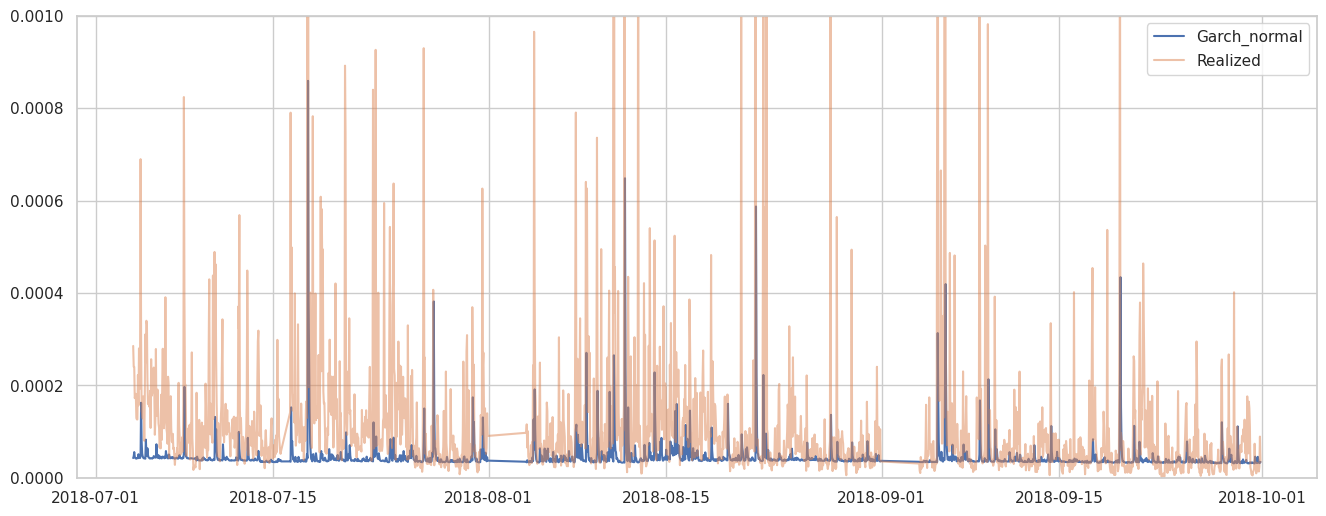

In [37]:
backtest_results_garch = backtester.backtest(
    GARCH,
    hyperparams={"p": 1, "o": 0, "q": 1, "dist": "normal"},
    use_ob_feats=False,
    use_log_y=False,
)

In [19]:
backtest_results_garch.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"garch_{suffix}.csv",
    index=True,
)

### GARCH(1, 1) with Student's t dist. 

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.769e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-pack

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2892.06
Distribution:      Standardized Student's t   AIC:                           5794.13
Method:                  Maximum Likelihood   BIC:                           5816.09
                                              No. Observations:                  597
Date:                      Mon, Jun 30 2025   Df Residuals:                      596
Time:                              14:17:33   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10

  6%|▌         | 109/1958 [00:01<00:15, 115.58it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.201e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  7%|▋         | 133/1958 [00:01<00:24, 74.31it/s] 

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2118.21
Distribution:      Standardized Student's t   AIC:                          -4226.41
Method:                  Maximum Likelihood   BIC:                          -4203.54
                                              No. Observations:                  716
Date:                      Mon, Jun 30 2025   Df Residuals:                      715
Time:                              14:17:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 12%|█▏        | 230/1958 [00:02<00:15, 110.82it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.746e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 13%|█▎        | 254/1958 [00:03<00:19, 86.07it/s] 

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -45730.1
Distribution:      Standardized Student's t   AIC:                           91470.1
Method:                  Maximum Likelihood   BIC:                           91493.8
                                              No. Observations:                  833
Date:                      Mon, Jun 30 2025   Df Residuals:                      832
Time:                              14:17:35   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 17%|█▋        | 336/1958 [00:03<00:15, 105.99it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.95e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 18%|█▊        | 359/1958 [00:04<00:20, 79.32it/s] 

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -13067.8
Distribution:      Standardized Student's t   AIC:                           26145.5
Method:                  Maximum Likelihood   BIC:                           26169.7
                                              No. Observations:                  936
Date:                      Mon, Jun 30 2025   Df Residuals:                      935
Time:                              14:17:36   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 23%|██▎       | 453/1958 [00:05<00:17, 88.18it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.673e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 24%|██▎       | 462/1958 [00:05<00:26, 56.55it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2840.44
Distribution:      Standardized Student's t   AIC:                          -5670.87
Method:                  Maximum Likelihood   BIC:                          -5646.06
                                              No. Observations:                 1055
Date:                      Mon, Jun 30 2025   Df Residuals:                     1054
Time:                              14:17:38   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

 29%|██▉       | 571/1958 [00:06<00:13, 105.75it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.669e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 30%|███       | 597/1958 [00:07<00:12, 105.67it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4972.78
Distribution:      Standardized Student's t   AIC:                           9955.56
Method:                  Maximum Likelihood   BIC:                           9980.90
                                              No. Observations:                 1174
Date:                      Mon, Jun 30 2025   Df Residuals:                     1173
Time:                              14:17:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -8

 33%|███▎      | 641/1958 [00:07<00:10, 131.06it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.613e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.1

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                722.785
Distribution:      Standardized Student's t   AIC:                          -1435.57
Method:                  Maximum Likelihood   BIC:                          -1409.93
                                              No. Observations:                 1246
Date:                      Mon, Jun 30 2025   Df Residuals:                     1245
Time:                              14:17:40   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

 38%|███▊      | 745/1958 [00:08<00:08, 138.60it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.587e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 40%|███▉      | 775/1958 [00:08<00:10, 117.03it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                3845.15
Distribution:      Standardized Student's t   AIC:                          -7680.30
Method:                  Maximum Likelihood   BIC:                          -7654.29
                                              No. Observations:                 1342
Date:                      Mon, Jun 30 2025   Df Residuals:                     1341
Time:                              14:17:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

 44%|████▍     | 863/1958 [00:09<00:08, 131.01it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.974e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 45%|████▌     | 890/1958 [00:09<00:10, 103.75it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                4761.37
Distribution:      Standardized Student's t   AIC:                          -9512.75
Method:                  Maximum Likelihood   BIC:                          -9486.31
                                              No. Observations:                 1462
Date:                      Mon, Jun 30 2025   Df Residuals:                     1461
Time:                              14:17:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 50%|████▉     | 973/1958 [00:10<00:08, 109.93it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 51%|█████     | 997/1958 [00:10<00:10, 91.24it/s] 

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                4453.88
Distribution:      Standardized Student's t   AIC:                          -8897.76
Method:                  Maximum Likelihood   BIC:                          -8870.94
                                              No. Observations:                 1581
Date:                      Mon, Jun 30 2025   Df Residuals:                     1580
Time:                              14:17:43   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

 56%|█████▌    | 1098/1958 [00:11<00:07, 122.12it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.125e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 57%|█████▋    | 1125/1958 [00:11<00:08, 103.68it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -84385.3
Distribution:      Standardized Student's t   AIC:                           168781.
Method:                  Maximum Likelihood   BIC:                           168808.
                                              No. Observations:                 1701
Date:                      Mon, Jun 30 2025   Df Residuals:                     1700
Time:                              14:17:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            93

 62%|██████▏   | 1211/1958 [00:12<00:05, 125.06it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.875e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 63%|██████▎   | 1240/1958 [00:12<00:06, 106.75it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2026.61
Distribution:      Standardized Student's t   AIC:                          -4043.22
Method:                  Maximum Likelihood   BIC:                          -4015.68
                                              No. Observations:                 1820
Date:                      Mon, Jun 30 2025   Df Residuals:                     1819
Time:                              14:17:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 67%|██████▋   | 1318/1958 [00:13<00:04, 150.00it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.742e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -145164.
Distribution:      Standardized Student's t   AIC:                           290338.
Method:                  Maximum Likelihood   BIC:                           290366.
                                              No. Observations:                 1916
Date:                      Mon, Jun 30 2025   Df Residuals:                     1915
Time:                              14:17:46   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

 71%|███████   | 1388/1958 [00:13<00:03, 155.68it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.834e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 72%|███████▏  | 1405/1958 [00:14<00:05, 110.52it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -739642.
Distribution:      Standardized Student's t   AIC:                       1.47929e+06
Method:                  Maximum Likelihood   BIC:                       1.47932e+06
                                              No. Observations:                 1988
Date:                      Mon, Jun 30 2025   Df Residuals:                     1987
Time:                              14:17:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 77%|███████▋  | 1505/1958 [00:14<00:02, 163.28it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.738e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 79%|███████▊  | 1539/1958 [00:15<00:03, 135.41it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6083.18
Distribution:      Standardized Student's t   AIC:                           12176.4
Method:                  Maximum Likelihood   BIC:                           12204.6
                                              No. Observations:                 2102
Date:                      Mon, Jun 30 2025   Df Residuals:                     2101
Time:                              14:17:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4

 82%|████████▏ | 1611/1958 [00:15<00:02, 165.30it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.556e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 84%|████████▍ | 1648/1958 [00:15<00:02, 128.65it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -95688.1
Distribution:      Standardized Student's t   AIC:                           191386.
Method:                  Maximum Likelihood   BIC:                           191415.
                                              No. Observations:                 2221
Date:                      Mon, Jun 30 2025   Df Residuals:                     2220
Time:                              14:17:48   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

 88%|████████▊ | 1728/1958 [00:16<00:01, 149.76it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.519e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 90%|████████▉ | 1759/1958 [00:16<00:01, 121.43it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -29332.7
Distribution:      Standardized Student's t   AIC:                           58675.5
Method:                  Maximum Likelihood   BIC:                           58704.3
                                              No. Observations:                 2341
Date:                      Mon, Jun 30 2025   Df Residuals:                     2340
Time:                              14:17:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -26

 95%|█████████▍| 1860/1958 [00:17<00:00, 192.82it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 97%|█████████▋| 1905/1958 [00:17<00:00, 198.03it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -545.401
Distribution:      Standardized Student's t   AIC:                           1100.80
Method:                  Maximum Likelihood   BIC:                           1129.84
                                              No. Observations:                 2461
Date:                      Mon, Jun 30 2025   Df Residuals:                     2460
Time:                              14:17:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

100%|██████████| 1958/1958 [00:17<00:00, 110.88it/s]


Backtest finished successfully.
---------------------------------------------------
Model: GARCH_studentst
RMSE: 1991129089686611.0000000
MAE:  450896575880320.3125000
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


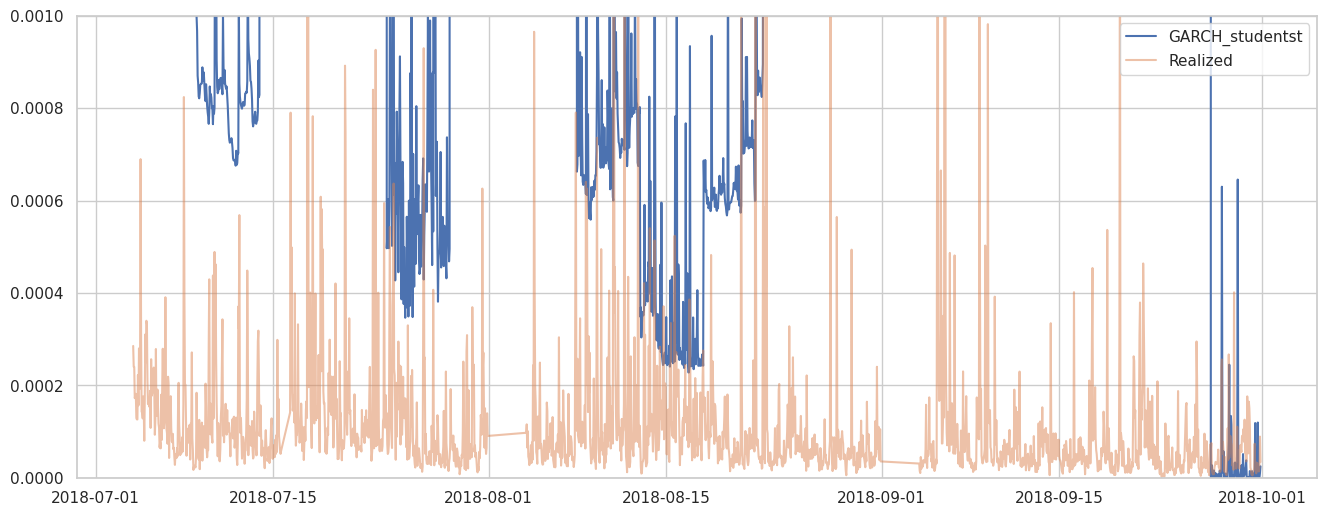

In [ ]:
backtest_results_egarch = backtester.backtest(
    GARCH,
    hyperparams={"p": 1, "o": 0, "q": 1, "dist": "studentst", "type": "GARCH"},
    use_ob_feats=False,
    use_log_y=False,
)

Using t-distribution (skewed or not) leads to convergence issues, even in the expanding window. 

## HAR

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|███▏      | 636/1958 [00:02<00:04, 307.70it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py

Backtest finished successfully.
---------------------------------------------------
Model: HAR
RMSE: 0.0002304
MAE:  0.0000858
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


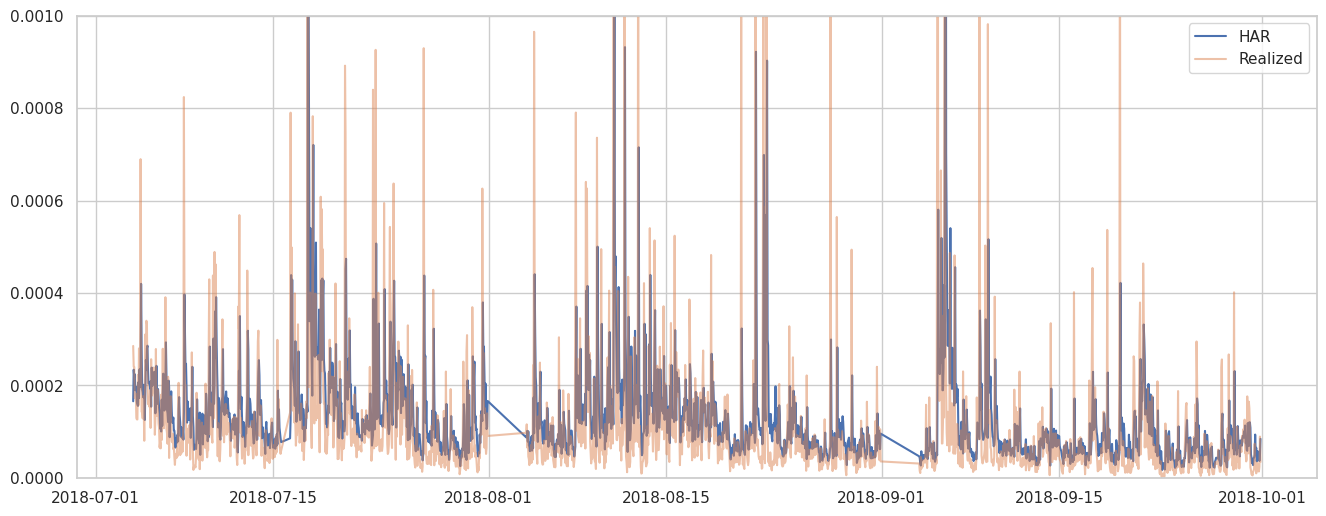

In [21]:
backtest_results_har = backtester.backtest(
    HARX,
    hyperparams={"lags": [1, 6, 24], "l2": 0.0, "is_weighted": False},
    use_ob_feats=False,
    use_log_y=True,
)

In [22]:
backtest_results_har.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"har_{suffix}.csv",
    index=True,
)

# Backtesting Multivariate models

## ARIMAX

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 9/1958 [00:00<01:35, 20.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  597
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -484.588
Date:                Mon, 30 Jun 2025   AIC                            987.175
Time:                        14:17:58   BIC                           1026.702
Sample:                             0   HQIC                          1002.566
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0772      0.746    -13.502      0.000     -11.540      -8.614
x1             0.3485      0.041      8.581      0.000       0.269       0.428
x2             0.1916      0.021      8.938      0.0

  6%|▌         | 113/1958 [00:01<00:20, 91.52it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 132/1958 [00:02<00:50, 36.04it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  716
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -582.208
Date:                Mon, 30 Jun 2025   AIC                           1182.416
Time:                        14:18:00   BIC                           1223.579
Sample:                             0   HQIC                          1198.311
                                - 716                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2690      0.831    -12.360      0.000     -11.897      -8.641
x1             0.3602      0.037      9.646      0.000       0.287       0.433
x2             0.1796      0.020      9.191      0.0

 12%|█▏        | 234/1958 [00:04<00:21, 79.71it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 13%|█▎        | 251/1958 [00:04<00:40, 42.29it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -690.689
Date:                Mon, 30 Jun 2025   AIC                           1399.379
Time:                        14:18:02   BIC                           1441.904
Sample:                             0   HQIC                          1415.684
                                - 833                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.3370      0.836    -12.362      0.000     -11.976      -8.698
x1             0.3631      0.036     10.031      0.000       0.292       0.434
x2             0.1802      0.016     10.972      0.0

 17%|█▋        | 333/1958 [00:05<00:21, 74.76it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 18%|█▊        | 349/1958 [00:06<00:41, 38.38it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  936
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -816.476
Date:                Mon, 30 Jun 2025   AIC                           1650.953
Time:                        14:18:04   BIC                           1694.527
Sample:                             0   HQIC                          1667.567
                                - 936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9459      0.754    -15.841      0.000     -13.424     -10.468
x1             0.4042      0.036     11.267      0.000       0.334       0.474
x2             0.1765      0.018      9.873      0.0

 23%|██▎       | 451/1958 [00:07<00:19, 76.71it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 24%|██▍       | 466/1958 [00:09<01:06, 22.34it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1055
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -932.655
Date:                Mon, 30 Jun 2025   AIC                           1883.310
Time:                        14:18:07   BIC                           1927.961
Sample:                             0   HQIC                          1900.236
                               - 1055                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6465      0.508    -22.945      0.000     -12.641     -10.652
x1             0.4007      0.034     11.665      0.000       0.333       0.468
x2             0.1651      0.016     10.026      0.0

 30%|███       | 588/1958 [00:11<00:48, 28.14it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1174
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1075.788
Date:                Mon, 30 Jun 2025   AIC                           2169.577
Time:                        14:18:09   BIC                           2215.190
Sample:                             0   HQIC                          2186.778
                               - 1174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8132      0.370    -29.238      0.000     -11.538     -10.088
x1             0.4210      0.033     12.734      0.000       0.356       0.486
x2             0.1661      0.017     10.043      0.0

 33%|███▎      | 644/1958 [00:12<00:20, 63.60it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 34%|███▎      | 658/1958 [00:13<00:43, 29.62it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1246
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1163.877
Date:                Mon, 30 Jun 2025   AIC                           2345.753
Time:                        14:18:11   BIC                           2391.902
Sample:                             0   HQIC                          2363.105
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6894      0.375    -28.517      0.000     -11.424      -9.955
x1             0.4254      0.033     13.000      0.000       0.361       0.490
x2             0.1685      0.017      9.950      0.0

 38%|███▊      | 741/1958 [00:14<00:18, 65.46it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 39%|███▊      | 755/1958 [00:15<00:42, 28.07it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1342
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1273.404
Date:                Mon, 30 Jun 2025   AIC                           2564.807
Time:                        14:18:13   BIC                           2611.625
Sample:                             0   HQIC                          2582.346
                               - 1342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4671      0.363    -28.830      0.000     -11.179      -9.755
x1             0.4282      0.032     13.281      0.000       0.365       0.491
x2             0.1739      0.016     10.679      0.0

 44%|████▍     | 863/1958 [00:17<00:21, 51.28it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 45%|████▍     | 875/1958 [00:18<00:53, 20.12it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1448.575
Date:                Mon, 30 Jun 2025   AIC                           2915.149
Time:                        14:18:16   BIC                           2962.737
Sample:                             0   HQIC                          2932.900
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5020      0.339    -31.004      0.000     -11.166      -9.838
x1             0.4249      0.034     12.648      0.000       0.359       0.491
x2             0.1736      0.015     11.408      0.0

 50%|████▉     | 978/1958 [00:20<00:16, 60.36it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 51%|█████     | 991/1958 [00:21<00:39, 24.55it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1581
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1584.339
Date:                Mon, 30 Jun 2025   AIC                           3186.678
Time:                        14:18:19   BIC                           3234.970
Sample:                             0   HQIC                          3204.621
                               - 1581                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6018      0.326    -32.499      0.000     -11.241      -9.962
x1             0.4179      0.033     12.610      0.000       0.353       0.483
x2             0.1797      0.015     12.220      0.0

 56%|█████▌    | 1100/1958 [00:23<00:14, 57.96it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 57%|█████▋    | 1112/1958 [00:24<00:39, 21.45it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1701
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1745.227
Date:                Mon, 30 Jun 2025   AIC                           3508.453
Time:                        14:18:22   BIC                           3557.404
Sample:                             0   HQIC                          3526.574
                               - 1701                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7512      0.323    -33.324      0.000     -11.384     -10.119
x1             0.4213      0.033     12.844      0.000       0.357       0.486
x2             0.1850      0.014     12.761      0.0

 62%|██████▏   | 1223/1958 [00:26<00:14, 51.40it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 63%|██████▎   | 1229/1958 [00:27<00:48, 14.95it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1820
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1868.953
Date:                Mon, 30 Jun 2025   AIC                           3755.907
Time:                        14:18:25   BIC                           3805.466
Sample:                             0   HQIC                          3774.191
                               - 1820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9702      0.322    -34.096      0.000     -11.601     -10.340
x1             0.4225      0.031     13.454      0.000       0.361       0.484
x2             0.1973      0.015     13.607      0.0

 67%|██████▋   | 1315/1958 [00:29<00:12, 51.68it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 68%|██████▊   | 1326/1958 [00:30<00:34, 18.42it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1916
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1984.555
Date:                Mon, 30 Jun 2025   AIC                           3987.111
Time:                        14:18:28   BIC                           4037.133
Sample:                             0   HQIC                          4005.518
                               - 1916                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0130      0.338    -32.589      0.000     -11.675     -10.351
x1             0.4175      0.031     13.588      0.000       0.357       0.478
x2             0.2066      0.015     14.068      0.0

 71%|███████   | 1388/1958 [00:31<00:11, 50.28it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|███████▏  | 1398/1958 [00:32<00:33, 16.88it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1988
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2088.843
Date:                Mon, 30 Jun 2025   AIC                           4195.685
Time:                        14:18:30   BIC                           4246.039
Sample:                             0   HQIC                          4214.180
                               - 1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0789      0.346    -31.998      0.000     -11.758     -10.400
x1             0.4287      0.031     14.014      0.000       0.369       0.489
x2             0.2066      0.015     13.888      0.0

 77%|███████▋  | 1501/1958 [00:34<00:09, 50.42it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|███████▋  | 1507/1958 [00:36<00:31, 14.19it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2102
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2226.737
Date:                Mon, 30 Jun 2025   AIC                           4471.474
Time:                        14:18:34   BIC                           4522.330
Sample:                             0   HQIC                          4490.101
                               - 2102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0265      0.369    -29.902      0.000     -11.749     -10.304
x1             0.4361      0.030     14.688      0.000       0.378       0.494
x2             0.2085      0.015     14.069      0.0

 83%|████████▎ | 1630/1958 [00:40<00:26, 12.22it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2221
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2362.848
Date:                Mon, 30 Jun 2025   AIC                           4743.697
Time:                        14:18:38   BIC                           4795.048
Sample:                             0   HQIC                          4762.452
                               - 2221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9518      0.397    -27.574      0.000     -11.730     -10.173
x1             0.4455      0.027     16.336      0.000       0.392       0.499
x2             0.2080      0.015     14.003      0.0

 89%|████████▉ | 1743/1958 [00:43<00:05, 42.83it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▉ | 1748/1958 [00:44<00:25,  8.36it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2341
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2526.025
Date:                Mon, 30 Jun 2025   AIC                           5070.051
Time:                        14:18:42   BIC                           5121.876
Sample:                             0   HQIC                          5088.929
                               - 2341                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9778      0.383    -28.628      0.000     -11.729     -10.226
x1             0.4534      0.027     16.986      0.000       0.401       0.506
x2             0.2152      0.015     14.833      0.0

 95%|█████████▍| 1860/1958 [00:47<00:02, 37.74it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 95%|█████████▌| 1869/1958 [00:49<00:09,  9.21it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2461
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2703.019
Date:                Mon, 30 Jun 2025   AIC                           5424.037
Time:                        14:18:47   BIC                           5476.312
Sample:                             0   HQIC                          5443.031
                               - 2461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1721      0.498    -22.443      0.000     -12.148     -10.196
x1             0.4624      0.027     17.275      0.000       0.410       0.515
x2             0.2288      0.015     14.760      0.0

100%|██████████| 1958/1958 [00:52<00:00, 37.16it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMAX
RMSE: 0.0002403
MAE:  0.0000930
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


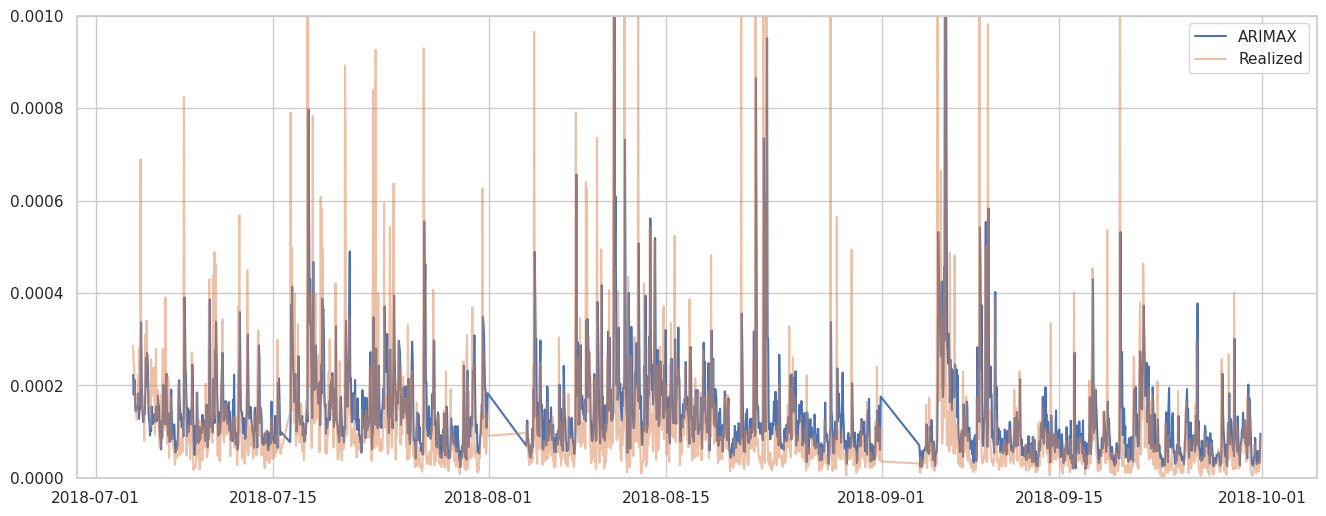

In [23]:
backtest_results_arimax = backtester.backtest(
    ARIMAX, hyperparams={"p": 1, "d": 0, "q": 2}, use_ob_feats=True, use_log_y=True
)

In [24]:
backtest_results_arimax.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arimax_{suffix}.csv",
    index=True,
)

## HARX

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 642/1958 [00:03<00:06, 203.71it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py

Backtest finished successfully.
---------------------------------------------------
Model: HARX
RMSE: 0.0002296
MAE:  0.0000821
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


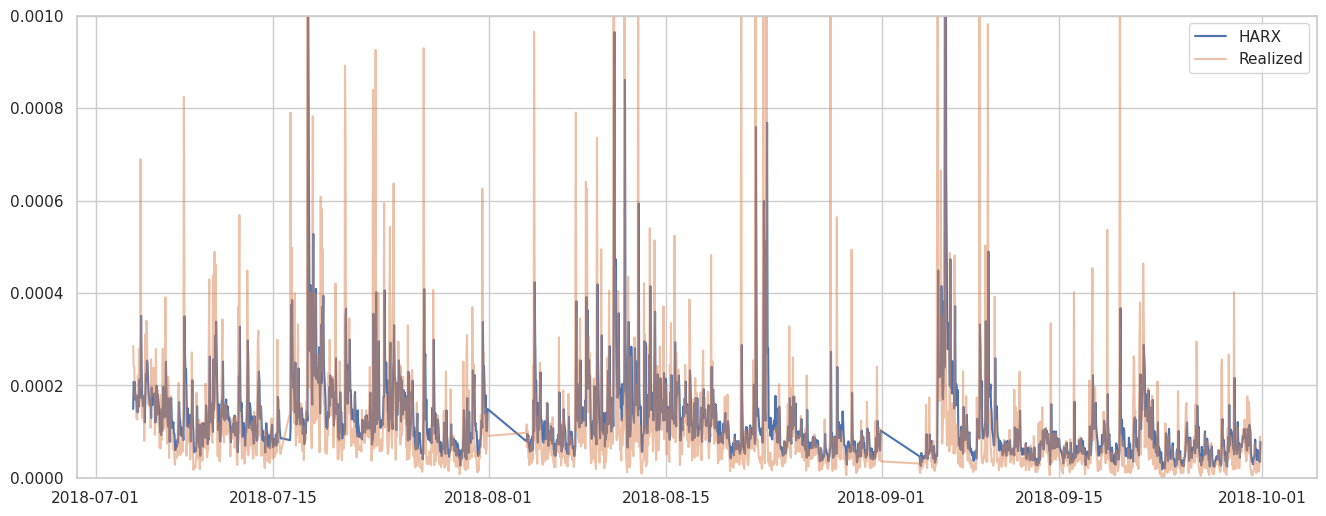

In [25]:
backtest_results_harx = backtester.backtest(
    HARX,
    hyperparams={"lags": [1, 6, 24], "l2": 100.0, "is_weighted": True},
    use_ob_feats=True,
    use_log_y=True,
)

In [26]:
backtest_results_harx.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"harx_{suffix}.csv",
    index=True,
)

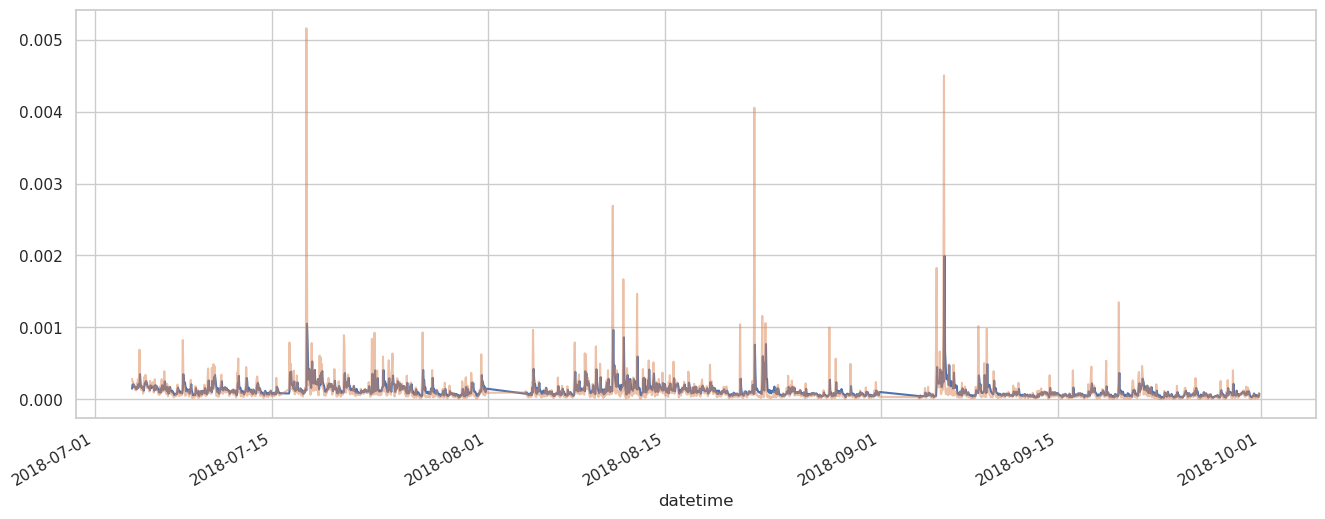

In [27]:
backtest_results_harx.forecasts.plot(label="HARX")
plt.plot(backtest_results_harx.true_vola, label="Realized", alpha=0.5)

## Elastic Net

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|███▏      | 631/1958 [00:04<00:06, 191.99it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py

Backtest finished successfully.
---------------------------------------------------
Model: ENET
RMSE: 0.0002320
MAE:  0.0000930
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


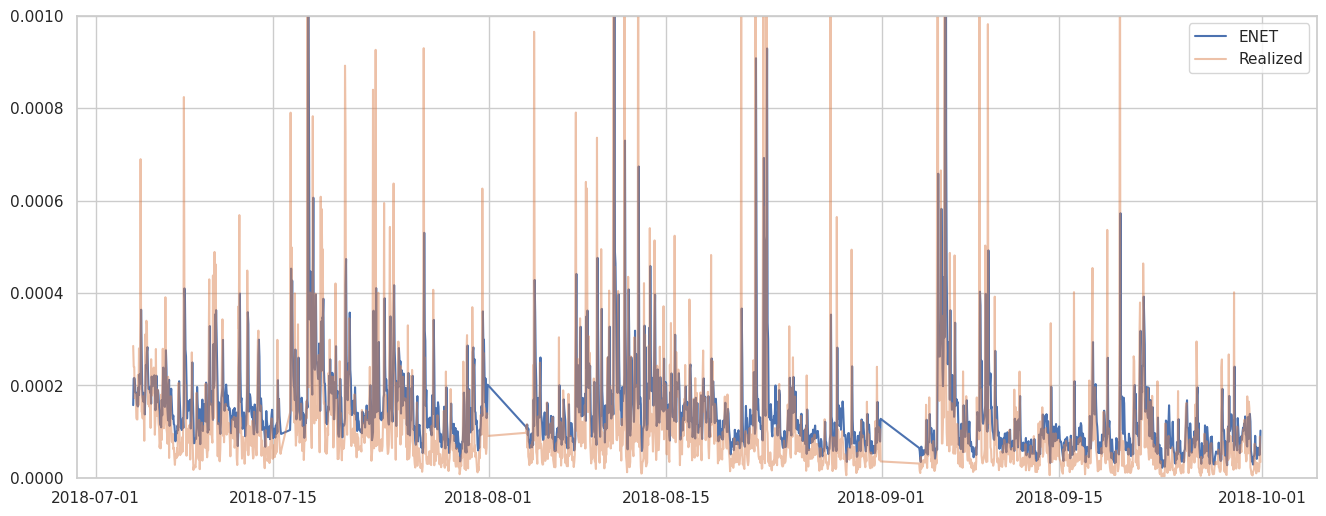

In [28]:
backtest_results_enet = backtester.backtest(
    ENET,
    hyperparams={"alpha": 0.1, "l1_ratio": 0.7, "num_vola_lags": 10},
    use_ob_feats=True,
    use_log_y=True,
)

In [29]:
backtest_results_enet.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"enet_{suffix}.csv",
    index=True,
)

## Random Forest

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 642/1958 [00:16<00:23, 57.06it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:

Backtest finished successfully.
---------------------------------------------------
Model: RF
RMSE: 0.0002318
MAE:  0.0000931
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


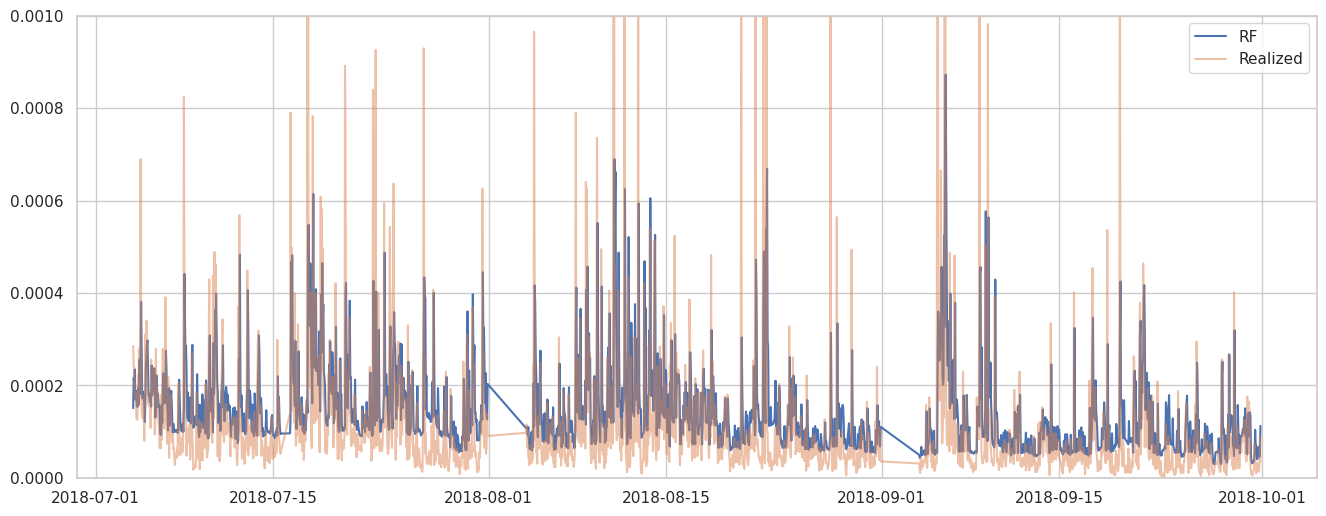

In [30]:
backtest_results_rf = backtester.backtest(
    RF,
    hyperparams={"n_estimators": 200, "max_depth": 3, "min_samples_split": 10},
    use_ob_feats=True,
    use_log_y=True,
)

In [31]:
backtest_results_rf.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"rf_{suffix}.csv",
    index=True,
)

## XGBM

  0%|          | 0/1958 [00:00<?, ?it/s]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:21:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 116/1958 [00:01<00:11, 155.58it/s]/home/miroslav/miniforge3/env

Backtest finished successfully.
---------------------------------------------------
Model: XGBM
RMSE: 0.0002316
MAE:  0.0000979
Expanding training set: True
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


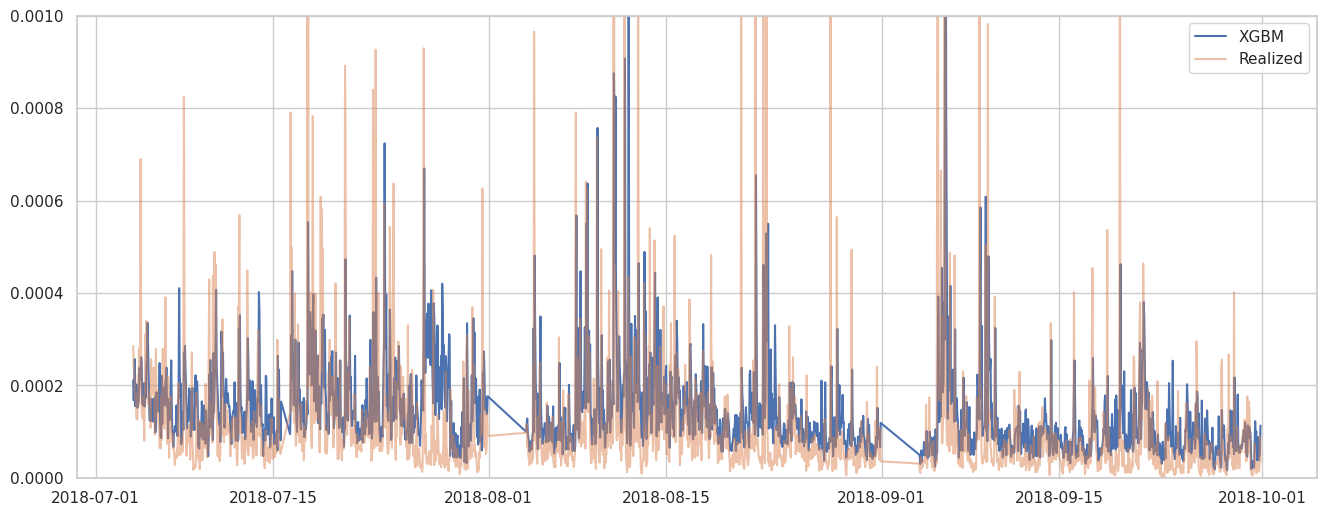

In [34]:
backtest_results_xgbm = backtester.backtest(
    XGBM,
    hyperparams={"n_estimators": 50, "max_depth": 3, "min_samples_split": 20},
    use_ob_feats=True,
    use_log_y=True,
)

In [33]:
backtest_results_xgbm.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"xgbm_{suffix}.csv",
    index=True,
)